#### Analisis
Entrenar un modelo Word2Vec para el español. Se puede utilizar agrupar datasets de "Sophia" en un solo dataset grande.

Entrenar distintos modelos de clasificación de textos, utilizando Word2Vec y sin utilizar Word2Vec, para resolver el problema de clasificación siguiente: reconocer automáticamente el medio qlas noticias según el nombre del medio.

In [9]:
from gensim.models import word2vec
from IPython.display import display, HTML
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression # Log classifier
from sklearn.model_selection import train_test_split # Split in train/test
from sklearn import metrics
import matplotlib.pyplot as plt
import gensim 
import numpy as np
import spacy
from sklearn.model_selection import StratifiedShuffleSplit # for split data (train/test)
from stop_words import get_stop_words # stop words
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier # MLP NN
from sklearn import svm # support vector machine

### Load data

In [10]:
# Analize data
df = pd.read_csv('dataset-cuarta_vs_tercera.csv', sep = '|', header = None)

# Get news and medium
df = df.iloc[:,[1,3]]

# display(df.iloc[1,1])

# Get dummies variables
dummies = pd.get_dummies(df[1], drop_first = True)
df = pd.concat([df, dummies], axis=1)      
df.drop([1], inplace=True, axis=1)

# Add names
df.columns = ['report', 'company']

# company:
# 0: La cuarta
# 1: La tercera

print(df.shape)
df.head()

(200, 2)


,report,company
0,Detectamos que JavaScript está desactivado en...,1
1,Detectamos que JavaScript está desactivado en...,1
2,Detectamos que JavaScript está desactivado en...,1
3,"Para los diputados, el informe de auditoría q...",1
4,Ayer se concretó el cierre del primer Centro ...,1


### Analize classes (for check balancing)

(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

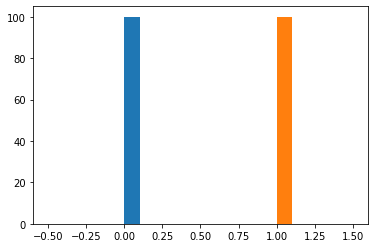

In [11]:
# Distribution of labels
fig, ax = plt.subplots()

# plot hist
ax.hist(df.loc[df['company'] == 0, 'company'], bins = 10)
ax.hist(df.loc[df['company'] == 1, 'company'], bins = 10)

#### Del gráfico anterior se tiene que las clases estan balanceadas.

### Define tokenizer of corpus

In [12]:
# Tokenizer

# Define own tokenizer

nlp = spacy.load('es_core_news_sm')

def own_tokenizer(sentence):
    
    tokens = []
    
    doc = nlp(sentence.lower().strip())
    
    for token in doc:
        
        # Filtering
        if not token.is_space and not token.is_stop and not token.is_punct and not token.is_digit and not token.like_num:
            
            # add token to list in lemma form
            tokens.append(token.lemma_)
            
    return tokens

# BOW and TFIDF development

### Stopwords to use in tokenizer

In [13]:
# Stop words (not has information)
stop_words = ['a','e','i','o','u',' ','  ','   ','  ','$','  ','y', '-', 'q','c', 'nna', 'e', 'l', '=', '<', '>','x','href','/',
             'JavaScript', 'navegador', '¿', 'Twitter', 'Tweets', 'web', 'URL']

# using stop words from library
stop_words_lib = get_stop_words('spanish')

# joining stop words
stop_words = stop_words + stop_words_lib

### Create vectorizer of BOW and TFIDF

In [14]:
# Vectorizer

# Bag of words
bow_vector = CountVectorizer(tokenizer = own_tokenizer, ngram_range = (1,1))

# TFIDF
tfidf_vector = TfidfVectorizer(tokenizer = own_tokenizer, ngram_range = (1,1))

### Get data individally

In [30]:
# Get data
X = df['report'] # the features we want to analyze
y = df['company'] # the labels, or answers, we want to test against

### Crate pipelines for BOW and TFIDF:

1) Apply the vectorization

2) Model to use

In [31]:
# Create pipelines

# Bag of words

# Create pipeline using logistic regression
pipe_bow_log = Pipeline([('bow vectorizer', bow_vector),
                 ('logistic regression', LogisticRegression(solver = 'lbfgs'))])

# Using extra trees classifier (it's base in decision tree (It's like a forest))
pipe_bow_extra_trees = Pipeline([
    ("bow vectorizer", bow_vector),
    ("extra trees", ExtraTreesClassifier(n_estimators=200))])

# using MLP
pipe_bow_MLP = Pipeline([
    ("bow vectorizer", bow_vector),
    ("MLP", MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(1000, 2), random_state=1))
])

# Using SVM
pipe_bow_SVM = Pipeline([
    ("bow vectorizer", bow_vector),
    ("SVM", svm.SVC(gamma='scale'))
])

# TFIDF

# log reg using tfidf
pipe_tfidf_log = Pipeline([('tfidf vectorizer', tfidf_vector),
                 ('logistic regression', LogisticRegression(solver = 'lbfgs'))])

# Using extra trees classifier (it's base in decision tree (It's like a forest))
pipe_tfidf_extra_trees = Pipeline([
    ("tfidf vectorizer", tfidf_vector),
    ("extra trees", ExtraTreesClassifier(n_estimators=200))])

# using MLP
pipe_tfidf_MLP = Pipeline([
    ("tfidf vectorizer", tfidf_vector),
    ("MLP", MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(1000, 2), random_state=1))
])

# Using SVM
pipe_tfidf_SVM = Pipeline([
    ("tfidf vectorizer", tfidf_vector),
    ("SVM", svm.SVC(gamma='scale'))
])


# LIST OF MODELS

# list of models
models_bow_tfidf = [
    ('bow + log reg', pipe_bow_log),
    ('bow + ext_tree', pipe_bow_extra_trees),
    ('bow + MLP', pipe_bow_MLP),
    ('bow + SVM', pipe_bow_SVM),
    
    ('tfidf + log reg', pipe_tfidf_log),
    ('tfidf + ext_tree', pipe_tfidf_extra_trees),
    ('tfidf + MLP', pipe_tfidf_MLP),
    ('tfidf + SVM', pipe_tfidf_SVM)
    
]

### Train each model (bow and tfidf) considering differentes sizes of trainig data. In each training, it gets the accuracy of each model and store in scores

In [32]:
# Train models

# store score of each model
scores = []

# differents size of training examples
num_train = np.linspace(start = 2, stop = y.size - 10, num = 5).astype(int)

# iterate through each model of bow and tfidf
for name, model in models_bow_tfidf:
    
    # restart scores for each model
    score = []
    
    print(name)
    
    # iterate over each train size
    for train_size in num_train:
        
        print('train size: ', train_size)
        
        test_size = 1 - (train_size / float(len(y)))
        
        sp = StratifiedShuffleSplit(n_splits=1, test_size = test_size)
        
        sp.get_n_splits(X, y)
        
        for train, test in sp.split(X, y):
            
            X_train, X_test = X[train], X[test]
            y_train, y_test = y[train], y[test]
            
            acc = (metrics.accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))
            
            score.append(acc)
    
    # add scores to list
    scores.append({
        'name': name,
        'accuracy': score
    })
    
    
scores

bow + log reg
train size:  2
train size:  49
train size:  96
train size:  143
train size:  190
bow + ext_tree
train size:  2
train size:  49
train size:  96
train size:  143
train size:  190
bow + MLP
train size:  2
train size:  49
train size:  96
train size:  143
train size:  190
bow + SVM
train size:  2
train size:  49
train size:  96
train size:  143
train size:  190
tfidf + log reg
train size:  2
train size:  49
train size:  96
train size:  143
train size:  190
tfidf + ext_tree
train size:  2
train size:  49
train size:  96
train size:  143
train size:  190
tfidf + MLP
train size:  2
train size:  49
train size:  96
train size:  143
train size:  190
tfidf + SVM
train size:  2
train size:  49
train size:  96
train size:  143
train size:  190


[{'name': 'bow + log reg',
  'accuracy': [0.6515151515151515,
   0.9403973509933775,
   0.8942307692307693,
   0.9137931034482759,
   1.0]},
 {'name': 'bow + ext_tree',
  'accuracy': [0.5,
   0.847682119205298,
   0.9519230769230769,
   0.9310344827586207,
   1.0]},
 {'name': 'bow + MLP',
  'accuracy': [0.5151515151515151,
   0.9139072847682119,
   0.5,
   0.603448275862069,
   1.0]},
 {'name': 'bow + SVM',
  'accuracy': [0.5404040404040404,
   0.7019867549668874,
   0.8173076923076923,
   0.7758620689655172,
   0.9090909090909091]},
 {'name': 'tfidf + log reg',
  'accuracy': [0.601010101010101,
   0.6887417218543046,
   0.7403846153846154,
   0.7758620689655172,
   0.9090909090909091]},
 {'name': 'tfidf + ext_tree',
  'accuracy': [0.5202020202020202,
   0.9205298013245033,
   0.9519230769230769,
   0.9655172413793104,
   1.0]},
 {'name': 'tfidf + MLP',
  'accuracy': [0.5,
   0.7284768211920529,
   0.7019230769230769,
   0.7068965517241379,
   0.9090909090909091]},
 {'name': 'tfidf + S

# Word2Vec development

### get data in format to w2v (tokenize each doc)

In [35]:
# Tokenize each doc
X_w2v = [ own_tokenizer(report) for report in df['report']]

In [36]:
# Transform list to ndarray
X_w2v = np.array(X_w2v)

### Get w2v model and the representation of each word in w2v

In [37]:
# Create w2v model
model_w2v = gensim.models.Word2Vec(X_w2v, size=100)

# Dictionary: key: each word, value: its w2v representation (vector)
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.syn0))

/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """


### Embedding of each doc (to format w2v)

In [38]:
# Embedding of docs using w2v
# this get a vector of each document of dimension (dimension_vector_w2v, 1), so the total array is (n_docs, dimension_vector_w2v)
class MeanEmbeddingVectorizer(object):
      
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        
        # This mean each dimension of each word in doc, it getting the w2v representation of each doc
        doc_w2v = np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
        
#         print(doc_w2v.shape)
#         print(doc_w2v)
        # Return vlaue
        return doc_w2v
    

### Pipelines for w2v:

1) Apply w2v transformation

2) Apply model to use

In [39]:
# pipe for traing using w2v

# using logistic regression
pipe_word2vec_log = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("logistic regression", LogisticRegression(solver = 'lbfgs'))])

# Using extra trees classifier (it's base in decision tree (It's like a forest))
pipe_word2vec_extra_trees = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", ExtraTreesClassifier(n_estimators=200))])

# using MLP
pipe_word2vec_MLP = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("MLP", MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(1000, 2), random_state=1))
])

# Using SVM
pipe_word2vec_SVM = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("SVM", svm.SVC(gamma='scale'))
])

# list of models
# Add new model here
models_w2v = [
    ('w2v + log regg', pipe_word2vec_log), 
    ('w2v + ext_trees', pipe_word2vec_extra_trees), 
    ('w2v + MLP', pipe_word2vec_MLP),
    ('w2v + SVM', pipe_word2vec_SVM),
]

### Train each model using w2v representation. Training is by differentes training sizes. For each model, it gets the accuracy and add it to score list

In [40]:
# get labels
y_w2v = df['company']

# iterate through each model of w2v
for name, model in models_w2v:
        
    score = []
    
    # iterate over each train size
    for train_size in num_train:
        
        test_size = 1 - (train_size / float(len(y_w2v)))
        
        sp = StratifiedShuffleSplit(n_splits=1, test_size = test_size)
        
        sp.get_n_splits(X_w2v, y_w2v)
        
        for train, test in sp.split(X_w2v, y_w2v):
            
            X_train_w2v, X_test_w2v = X[train], X[test]
            y_train_w2v, y_test_w2v = y[train], y[test]
            
            acc = (metrics.accuracy_score(model.fit(X_train_w2v, y_train_w2v).predict(X_test_w2v), y_test_w2v))
            
            score.append(acc)
    
    # add scores to list
    scores.append({
        'name': name,
        'accuracy': score
    })
    
    
scores

[{'name': 'bow + log reg',
  'accuracy': [0.6515151515151515,
   0.9403973509933775,
   0.8942307692307693,
   0.9137931034482759,
   1.0]},
 {'name': 'bow + ext_tree',
  'accuracy': [0.5,
   0.847682119205298,
   0.9519230769230769,
   0.9310344827586207,
   1.0]},
 {'name': 'bow + MLP',
  'accuracy': [0.5151515151515151,
   0.9139072847682119,
   0.5,
   0.603448275862069,
   1.0]},
 {'name': 'bow + SVM',
  'accuracy': [0.5404040404040404,
   0.7019867549668874,
   0.8173076923076923,
   0.7758620689655172,
   0.9090909090909091]},
 {'name': 'tfidf + log reg',
  'accuracy': [0.601010101010101,
   0.6887417218543046,
   0.7403846153846154,
   0.7758620689655172,
   0.9090909090909091]},
 {'name': 'tfidf + ext_tree',
  'accuracy': [0.5202020202020202,
   0.9205298013245033,
   0.9519230769230769,
   0.9655172413793104,
   1.0]},
 {'name': 'tfidf + MLP',
  'accuracy': [0.5,
   0.7284768211920529,
   0.7019230769230769,
   0.7068965517241379,
   0.9090909090909091]},
 {'name': 'tfidf + S

### Analyze results

### Compare results for bow, tfidf and w2v

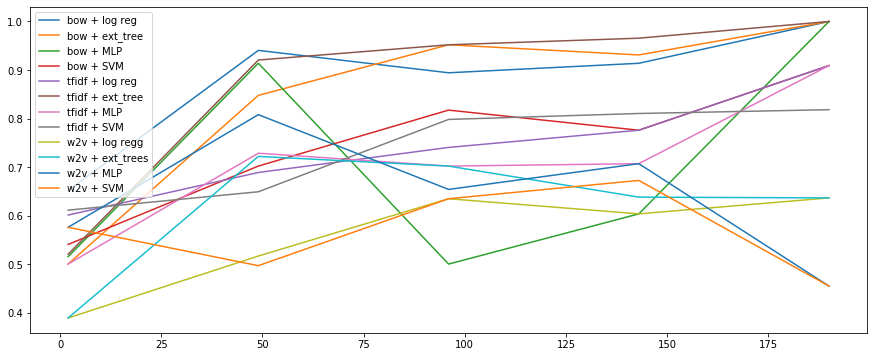

In [41]:
# plotting results
fig, ax = plt.subplots(figsize = (15,6))

# iterate over each model 
for model in scores:
    
    ax.plot(num_train, model['accuracy'], label = model['name'])
ax.legend()